##Importing Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization ,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

##Data Loading and Preprocessing

In [ ]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 400, 400, 3
MASK_CHANNELS = 1

In [ ]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/sorted_data.zip"  # Update this with the path to your zip file
unzip_dir = "/content/road_segmentation/"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print("Unzipping complete. Contents:")
print(os.listdir(unzip_dir))

Unzipping complete. Contents:
['content']


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Resize parameters
IMG_SIZE = (256, 256)
images_path = os.path.join(unzip_dir, "content/sorted_images")
masks_path = os.path.join(unzip_dir, "content/sorted_masks")

# Load and resize images
def load_and_resize(image_folder, mask_folder, img_size):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    for img_file, mask_file in zip(image_files, mask_files):
        # Load and resize image
        img = load_img(os.path.join(image_folder, img_file), target_size=img_size)
        mask = load_img(os.path.join(mask_folder, mask_file), target_size=img_size, color_mode="grayscale")

        # Convert to numpy array and normalize
        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)

    return np.array(images), np.array(masks)

# Load the images and masks
X, y = load_and_resize(images_path, masks_path, IMG_SIZE)

print(f"Loaded {len(X)} images and {len(y)} masks.")
print(f"Image shape: {X[0].shape}, Mask shape: {y[0].shape}")

Loaded 700 images and 700 masks.
Image shape: (256, 256, 3), Mask shape: (256, 256, 1)


In [ ]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")


Train set: 560 images
Validation set: 70 images
Test set: 70 images


##Model

In [ ]:
# Custom F1-score Metric
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score


def f1_score_metric(y_true, y_pred):
    y_pred_binary = K.round(y_pred)  # Convert predictions to binary
    precision = K.sum(y_true * y_pred_binary) / (K.sum(y_pred_binary) + K.epsilon())
    recall = K.sum(y_true * y_pred_binary) / (K.sum(y_true) + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
# Set random seeds for reproducibility
import random

def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

In [ ]:
#Model Architecture
from tensorflow.keras.layers import Lambda , UpSampling2D

from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 with weights from ImageNet
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze initial layers (we will train only the top layers)
for layer in vgg_base.layers[:15]:  # Freeze the first 15 layers
    layer.trainable = False

# VGG16 base outputs feature maps for skip connections
c1 = vgg_base.get_layer('block1_conv2').output  # 256x256x64
p1 = MaxPooling2D((2, 2))(c1)                  # 128x128x64

c2 = vgg_base.get_layer('block2_conv2').output  # 128x128x128
p2 = MaxPooling2D((2, 2))(c2)                  # 64x64x128

c3 = vgg_base.get_layer('block3_conv3').output  # 64x64x256
p3 = MaxPooling2D((2, 2))(c3)                  # 32x32x256

c4 = vgg_base.get_layer('block4_conv3').output  # 32x32x512
p4 = MaxPooling2D((2, 2))(c4)                  # 16x16x512

c5 = vgg_base.get_layer('block5_conv3').output  # 16x16x512

# Decoder with skip connections
u6 = UpSampling2D((2, 2))(c5)  # 32x32x512
u6 = concatenate([u6, c4])     # Align spatial dimensions
c6 = Conv2D(256, (3, 3), padding='same', activation='relu')(u6)

u7 = UpSampling2D((2, 2))(c6)  # 64x64x256
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), padding='same', activation='relu')(u7)

u8 = UpSampling2D((2, 2))(c7)  # 128x128x128
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), padding='same', activation='relu')(u8)

u9 = UpSampling2D((2, 2))(c8)  # 256x256x64
u9 = concatenate([u9, c1])
c9 = Conv2D(64, (3, 3), padding='same', activation='relu')(u9)

# Final segmentation layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

# Define the model
model = Model(inputs=vgg_base.input, outputs=outputs)

In [ ]:
#Loss Function
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Stop if val_loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True,  # Restore model weights from the epoch with the best val_loss
    verbose=1
)

# Reduce Learning Rate on Plateau Callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

optimizer=Adam(learning_rate=5e-4)
model.compile(
    optimizer=optimizer,
    loss=lambda y_true, y_pred: dice_loss(y_true, y_pred),
    metrics=[Precision(), Recall(), f1_score_metric]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 17,885,569 (68.23 MB)

 Trainable params: 10,250,305 (39.10 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Train the model with Early Stopping and Learning Rate Scheduler
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=250,
    callbacks=[early_stopping, lr_scheduler],  # Add EarlyStopping and ReduceLROnPlateau
    verbose=1
)

Epoch 1/250
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 987ms/step - f1_score_metric: 0.3748 - loss: 0.6234 - precision: 0.3079 - recall: 0.6972 - val_f1_score_metric: 0.5977 - val_loss: 0.4094 - val_precision: 0.6943 - val_recall: 0.5491 - learning_rate: 5.0000e-04
Epoch 2/250
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - f1_score_metric: 0.6364 - loss: 0.3637 - precision: 0.6884 - recall: 0.6510 - val_f1_score_metric: 0.7078 - val_loss: 0.2965 - val_precision: 0.7634 - val_recall: 0.7005 - learning_rate: 5.0000e-04
Epoch 3/250
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - f1_score_metric: 0.7315 - loss: 0.2688 - precision: 0.8145 - recall: 0.7091 - val_f1_score_metric: 0.7593 - val_loss: 0.2457 - val_precision: 0.8671 - val_recall: 0.6912 - learning_rate: 5.0000e-04
Epoch 4/250
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - f1_score_metric: 0.7823 - loss: 0.2181 - precision: 0.8715 - recall: 0.7483 - val_f1_score_metric: 0.7772 - val_loss: 0.2244 - val_precision: 0.8021 - val_recall: 0.8390 - learning_r

In [ ]:
from sklearn.metrics import f1_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Threshold the true labels (if they are continuous) and predicted labels at 0.5
y_test_binary = (y_test > 0.5).astype(np.uint8)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Flatten for F1-score calculation
y_true_flat = y_test_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Calculate F1-score
f1 = f1_score(y_true_flat, y_pred_flat)
print(f"F1-Score on Test Set: {f1:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step
F1-Score on Test Set: 0.9046


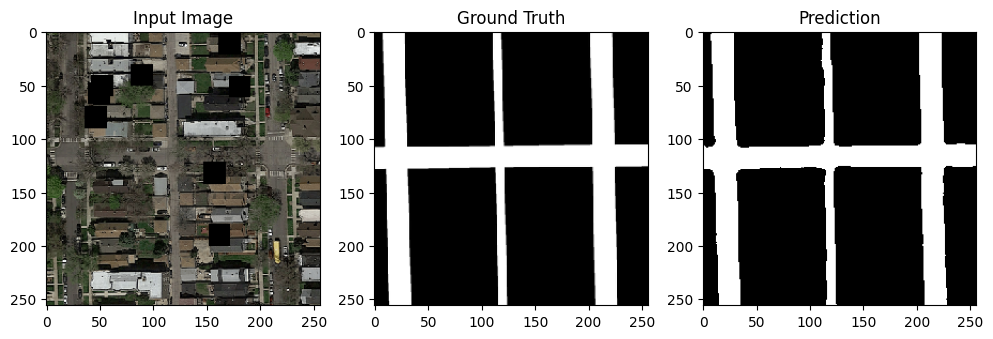

In [ ]:
import matplotlib.pyplot as plt

# Show sample predictions
def visualize_predictions(X, y_true, y_pred_binary, idx=0):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X[idx])

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y_true[idx].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(y_pred_binary[idx].squeeze(), cmap='gray')

    plt.show()

# Visualize a sample
visualize_predictions(X_test, y_test, y_pred_binary, idx=40)